# Assignment: Basic Web Scrapping and more...

Fill in your name here.

In [1]:
name = 'Uliana Mitiusheva'
if name == '':
    raise NotImplementedError('Put your name')

You will receive points for:
- implementing the given tasks.
- using good practices such as OOP in some cases, or decorators.
- good code structure on the last task.
- handling edge cases and exceptions.
- comprehensive unit tests (by using any of the libraries seen. I recommend `unittest`).

We will need the following libraries, but of course you can add the libraries you prefer.

In [3]:
for _ in range(2):
    try:
        from bs4 import BeautifulSoup
        import requests
        import unittest
        import networkx as nx
        import re
        from functools import wraps
        from urllib.parse import urljoin
        import types
        import matplotlib.pyplot as plt
    except ImportError:
        ! pip install beautifulsoup4
        ! pip install requests
        ! pip install unittest2
        ! pip install networkx
    else:
        break

## Task 1

The following function receives a URL, and tries to fetch all the links on it, and returns a list with all those links.

1. Modify the function so that it returns the expected links.

2. Be sure to do unit testing to check that the behaviour of the function is the one we expect.

3. Consider edge cases (for example, what if the given URL is not a valid URL).

In [73]:
def get_all_links(url: str):
    if not isinstance(url, str):
        raise ValueError("URL must be a string")
    if not (url.startswith("http://") or url.startswith("https://")):
        raise ValueError("URL is not valid")
    if " " in url:
        raise ValueError("URL must not contain spaces")

    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        raise ConnectionError(f"Failed to fetch the URL: {e}")

    content_type = response.headers.get('Content-Type', '')
    if 'text/html' not in content_type.lower():
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        absolute_url = urljoin(url, href)
        if absolute_url.startswith("http://") or absolute_url.startswith("https://"):
            links.append(absolute_url)
    return links

In [74]:
class TestGetAllLinks(unittest.TestCase):
  def test_valid_ur(self):
    url = "https://www.example.com"
    links = get_all_links(url)
    self.assertIsInstance(links, list)

  def test_invalid_url(self):
      with self.assertRaises(ValueError):
          get_all_links("invalid_url")

  def test_url_with_space(self):
      with self.assertRaises(ValueError):
          get_all_links("https://www. example.com")

  def test_non_string_url(self):
      with self.assertRaises(ValueError):
          get_all_links(123)

  def test_nonexistent_url(self):
      with self.assertRaises(ConnectionError):
          get_all_links("https://nonexistentwebsite.com")

  def test_non_html_content_type_returns_empty_list(self):
        url = "https://api.github.com"
        links = get_all_links(url)
        self.assertEqual(links, [], "Expected an empty list from a JSON (non-HTML) response.")

  def test_html_content_without_links_returns_empty_list(self):
        url = "https://httpbin.org/html"
        links = get_all_links(url)
        self.assertEqual(links, [], "Expected an empty list from an HTML page with no anchor tags.")

In [75]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestGetAllLinks)

runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_html_content_without_links_returns_empty_list (__main__.TestGetAllLinks.test_html_content_without_links_returns_empty_list) ... ok
test_invalid_url (__main__.TestGetAllLinks.test_invalid_url) ... ok
test_non_html_content_type_returns_empty_list (__main__.TestGetAllLinks.test_non_html_content_type_returns_empty_list) ... ok
test_non_string_url (__main__.TestGetAllLinks.test_non_string_url) ... ok
test_nonexistent_url (__main__.TestGetAllLinks.test_nonexistent_url) ... ok
test_url_with_space (__main__.TestGetAllLinks.test_url_with_space) ... ok
test_valid_ur (__main__.TestGetAllLinks.test_valid_ur) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.334s

OK


<unittest.runner.TextTestResult run=7 errors=0 failures=0>

In [76]:
get_all_links('http://en.wikipedia.com')[:10]

['http://en.wikipedia.com#bodyContent',
 'http://en.wikipedia.com/wiki/Main_Page',
 'http://en.wikipedia.com/wiki/Wikipedia:Contents',
 'http://en.wikipedia.com/wiki/Portal:Current_events',
 'http://en.wikipedia.com/wiki/Special:Random',
 'http://en.wikipedia.com/wiki/Wikipedia:About',
 'http://en.wikipedia.org/wiki/Wikipedia:Contact_us',
 'http://en.wikipedia.com/wiki/Help:Contents',
 'http://en.wikipedia.com/wiki/Help:Introduction',
 'http://en.wikipedia.com/wiki/Wikipedia:Community_portal']

## Task 2

Create a generator (`get_neighbor_pages`) that receives a URL, but instead of returning a list with all the links in that page, it should go to those links, and  **yield** their html content.

Remember to add unit tests.

In [77]:
def get_neighbor_pages(url):
    try:
        links = get_all_links(url)
    except ConnectionError as e:
        print(f"Error fetching the main URL {url}: {e}")
        return

    for link in links:
        try:
            response = requests.get(link)
            response.raise_for_status()
            if 'text/html' in response.headers.get('Content-Type', '').lower():
                yield response.text
        except requests.exceptions.RequestException as e:
            print(f"Error fetching {link}: {e}")
            continue

In [78]:
class TestGetNeighborPages(unittest.TestCase):
    def test_generator_type(self):
        url = "https://www.example.com"
        pages = get_neighbor_pages(url)
        self.assertIsInstance(pages, types.GeneratorType)

    def test_yields_html_content(self):
        url = "https://www.example.com"
        pages = get_neighbor_pages(url)
        first_page = next(pages, None)
        self.assertIsNotNone(first_page, "Generator did not yield any pages.")
        self.assertIsInstance(first_page, str, "Yielded page is not a string.")
        self.assertIn('<html', first_page.lower(), "Yielded content does not contain HTML.")

    def test_invalid_url(self):
        url = "invalid_url"
        with self.assertRaises(ValueError) as context:
            list(get_neighbor_pages(url))
        self.assertEqual(str(context.exception), "URL is not valid")

    def test_nonexistent_url(self):
        url = "https://nonexistentwebsite123456789.com"
        pages = get_neighbor_pages(url)
        result = list(pages)
        self.assertEqual(result, [], "Nonexistent URL should yield no pages.")


In [79]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestGetNeighborPages)

runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_generator_type (__main__.TestGetNeighborPages.test_generator_type) ... ok
test_invalid_url (__main__.TestGetNeighborPages.test_invalid_url) ... ok
test_nonexistent_url (__main__.TestGetNeighborPages.test_nonexistent_url) ... ok
test_yields_html_content (__main__.TestGetNeighborPages.test_yields_html_content) ... 

Error fetching the main URL https://nonexistentwebsite123456789.com: Failed to fetch the URL: HTTPSConnectionPool(host='nonexistentwebsite123456789.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x795ef927c150>: Failed to resolve 'nonexistentwebsite123456789.com' ([Errno -2] Name or service not known)"))


ok

----------------------------------------------------------------------
Ran 4 tests in 0.432s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

## Task 3

Create a function (`get_pages_depth()`) that receives a URL and a number `depth`, that will go through all the links the given URL, as deep as the given depth.

For example, let's say the current page `page_1` has a link to a page `page_2` and a link to a page `page_3`, and the page `page_2` has a link to a page `page_4`,  and `page_4` has a link to a page `page_5`, and `page_3` has a link to a page `page_6`, and `page_6` has a link to a page `page_7`.

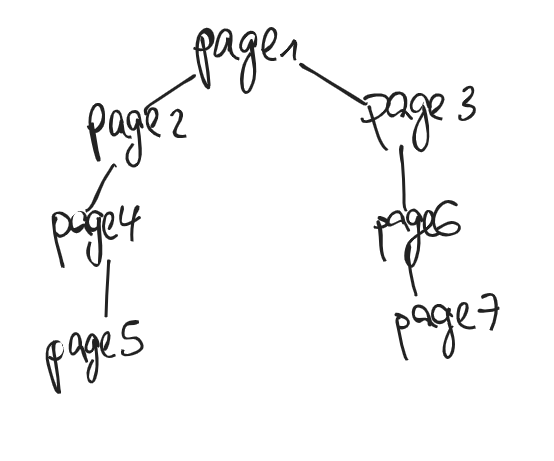

Then, if we call `get_pages_depth()` at `page_1` with `depth = 2`, then it should retrieve the pages `page_1`, `page_2`, `page_4`, `page_3` and `page_6`. We won't care about the order in which these pages are retrieved.

- Implement the function as a generator.

- Remember that a page might contain a link to a parent page, so try to take that into account.

- Consider any other edge cases that might happen, such as two pages leading to the same page. In that case, that page should only be retrieved once.

- Maybe you can add a decorator to handle such cases?

In [80]:
def skip_visited(func):
    visited_pages = set()

    @wraps(func)
    def wrapper(*args, **kwargs):
        kwargs['visited_pages'] = visited_pages

        for page_content in func(*args, **kwargs):
            yield page_content

    return wrapper

In [81]:
@skip_visited
def get_pages_depth(url: str, depth: int, visited_pages=None):
    """
    Go as deep as the given depth through the links in the webpage at the given URL
    and yield the HTML content of each page found. Avoid revisiting pages already visited.

    :param url: A string that is the URL of the webpage.
    :param depth: An integer that is the maximum depth to explore.
    :param visited_pages: A set used to track pages that have been visited.
                         This is handled automatically by the decorator.
    """
    if visited_pages is None:
        visited_pages = set()

    queue = [(url, 0)]

    while queue:
        current_url, current_depth = queue.pop(0)

        if current_url in visited_pages:
            continue
        visited_pages.add(current_url)

        try:
            response = requests.get(current_url, timeout=5)
            response.raise_for_status()
            page_content = response.text
        except (requests.RequestException, requests.HTTPError):
            continue

        yield page_content

        if current_depth < depth:
            soup = BeautifulSoup(page_content, 'html.parser')
            for link in soup.find_all('a', href=True):
                new_url = urljoin(current_url, link['href'])
                if new_url not in visited_pages:
                    queue.append((new_url, current_depth + 1))

In [82]:
pages = get_pages_depth(depth = 2, url = 'http://en.wikipedia.org')

In [83]:
next(pages)

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-disabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-not-available" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8">\n<title>Wikipedia, the free encyclopedia</title>\n<script>(function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-di

## Task 4

Create a class `ComputerScientist` that will contain information such as `name`, `birthdate`, `major_achievements`, `alma_mater`, etc.

- Implement the methods you consider appropriate.

- Make unit tests to make sure the methods work alright.

Write a script to go to this [list of computer scientists](https://en.wikipedia.org/wiki/List_of_computer_scientists) and fetch information about 100 random scientists from this list, and create a python `list` containing `ComputerScientist()` objects with the information retrieved from the given link.

In [7]:
class ComputerScientist:
    def __init__(self, name, birthdate=None, major_achievements=None, alma_mater=None, field=None, notable_works=None):
        self.name = name
        self.birthdate = birthdate
        self.major_achievements = major_achievements if major_achievements else []
        self.alma_mater = alma_mater
        self.field = field if field else []
        self.notable_works = notable_works if notable_works else []

    def __str__(self):
        return f"{self.name} ({self.birthdate})"

    def to_dict(self):
        return {
            "Name": self.name,
            "Birthdate": self.birthdate,
            "Major Achievements": self.major_achievements,
            "Alma Mater": self.alma_mater,
            "Field": self.field,
            "Notable Works": self.notable_works
        }

In [8]:
class TestComputerScientist(unittest.TestCase):
    def setUp(self):
        self.cs = ComputerScientist(
            name="Alan Turing",
            birthdate="23 June 1912",
            major_achievements=["Turing Machine", "Breaking the Enigma code"],
            alma_mater="King's College, Cambridge",
            field=["Mathematics", "Computer Science"],
            notable_works=["On Computable Numbers", "Turing Test"]
        )

    def test_object_creation(self):
        self.assertEqual(self.cs.name, "Alan Turing")
        self.assertEqual(self.cs.birthdate, "23 June 1912")
        self.assertListEqual(self.cs.major_achievements, ["Turing Machine", "Breaking the Enigma code"])
        self.assertEqual(self.cs.alma_mater, "King's College, Cambridge")
        self.assertListEqual(self.cs.field, ["Mathematics", "Computer Science"])
        self.assertListEqual(self.cs.notable_works, ["On Computable Numbers", "Turing Test"])

    def test_str_method(self):
        self.assertEqual(str(self.cs), "Alan Turing (23 June 1912)")

    def test_to_dict_method(self):
        expected_dict = {
            "Name": "Alan Turing",
            "Birthdate": "23 June 1912",
            "Major Achievements": ["Turing Machine", "Breaking the Enigma code"],
            "Alma Mater": "King's College, Cambridge",
            "Field": ["Mathematics", "Computer Science"],
            "Notable Works": ["On Computable Numbers", "Turing Test"]
        }
        self.assertDictEqual(self.cs.to_dict(), expected_dict)

In [9]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestComputerScientist)

runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_object_creation (__main__.TestComputerScientist) ... ok
test_str_method (__main__.TestComputerScientist) ... ok
test_to_dict_method (__main__.TestComputerScientist) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [10]:
def fetch_computer_scientists_list(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the main list page: {e}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    scientists = []

    div_cols = soup.find_all('div', class_='div-col')

    for div in div_cols:
        links = div.find_all('a')
        for link in links:
            href = link.get('href')
            name = link.text.strip()
            if href and href.startswith('/wiki/') and not any(prefix in href for prefix in ['/wiki/Help:', '/wiki/Category:', '/wiki/File:', '/wiki/Special:']):
                scientists.append((name, href))

    return scientists

def extract_infobox(soup):
    infobox = soup.find('table', class_='infobox')
    data = {}

    if not infobox:
        return data

    for row in infobox.find_all('tr'):
        if row.th and row.td:
            key = row.th.text.strip().lower()
            value = row.td.text.strip()
            data[key] = value

    return data

def scrape_computer_scientist_data(base_url, relative_link):
    full_url = urljoin(base_url, relative_link)

    try:
        response = requests.get(full_url, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {full_url}: {e}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')
    infobox_data = extract_infobox(soup)

    name = soup.find('h1', id='firstHeading').text.strip()

    birthdate = None
    if 'born' in infobox_data:
        born_text = infobox_data['born']
        match = re.search(r'\d{1,2} \w+ \d{4}', born_text)
        if match:
            birthdate = match.group(0)

    alma_mater = infobox_data.get('alma mater', None)

    field = []
    if 'fields' in infobox_data:
        field = [f.strip() for f in infobox_data['fields'].split(',')]
    elif 'field' in infobox_data:
        field = [f.strip() for f in infobox_data['field'].split(',')]

    major_achievements = []
    if 'known for' in infobox_data:
        major_achievements = [achievement.strip() for achievement in infobox_data['known for'].split(',')]

    notable_works = []
    if 'notable works' in infobox_data:
        notable_works = [work.strip() for work in infobox_data['notable works'].split(',')]

    return ComputerScientist(
        name=name,
        birthdate=birthdate,
        major_achievements=major_achievements,
        alma_mater=alma_mater,
        field=field,
        notable_works=notable_works
    )

def get_random_scientists(scientists_list, count=100):
    if len(scientists_list) < count:
        return scientists_list
    return random.sample(scientists_list, count)


In [11]:
base_url = "https://en.wikipedia.org"
list_url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"

scientists = fetch_computer_scientists_list(list_url)
print(f"Total computer scientists found: {len(scientists)}")

if not scientists:
    print("No computer scientists found. Exiting.")
else:
  selected_scientists = get_random_scientists(scientists, count=100)
  print(f"Selected {len(selected_scientists)} random computer scientists.")

  computer_scientists = []
  for idx, (name, relative_link) in enumerate(selected_scientists, start=1):
      print(f"Scraping ({idx}/{len(selected_scientists)}): {name}")
      cs = scrape_computer_scientist_data(base_url, relative_link)
      if cs:
          computer_scientists.append(cs)

  print(f"Scraped data for {len(computer_scientists)} computer scientists.")

Total computer scientists found: 9
Selected 9 random computer scientists.
Scraping (1/9): List of computing people
Scraping (2/9): List of Jewish American computer scientists
Scraping (3/9): List of members of the National Academy of Sciences (computer and information sciences)
Scraping (4/9): List of pioneers in computer science
Scraping (5/9): List of programmers
Scraping (6/9): List of programming language researchers
Scraping (7/9): List of Russian IT developers
Scraping (8/9): List of Slovenian computer scientists
Scraping (9/9): List of Indian computer scientists
Scraped data for 9 computer scientists.


In [14]:
class TestScrapingFunctions(unittest.TestCase):
    def setUp(self):
        self.base_url = "https://en.wikipedia.org"
        self.list_url = "https://en.wikipedia.org/wiki/List_of_computer_scientists"
        self.turing_name = "Alan Turing"
        self.turing_link = "/wiki/Alan_Turing"

    def test_fetch_computer_scientists_list(self):
        scientists = fetch_computer_scientists_list(self.list_url)
        self.assertIsInstance(scientists, list)
        self.assertGreater(len(scientists), 0)
        for name, href in scientists:
            self.assertIsInstance(name, str)
            self.assertIsInstance(href, str)
            self.assertTrue(href.startswith("/wiki/"))

    def test_scrape_computer_scientist_data(self):
        cs = scrape_computer_scientist_data(self.base_url, self.turing_link)
        self.assertIsNotNone(cs)
        self.assertIsInstance(cs, ComputerScientist)
        self.assertIn("Alan Turing", cs.name)

In [15]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestScrapingFunctions)

runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_fetch_computer_scientists_list (__main__.TestScrapingFunctions) ... ok
test_scrape_computer_scientist_data (__main__.TestScrapingFunctions) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.938s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Task 5

Use the previously defined `ComputerScientist` class.

Add a new attribute `wikipedia_link` without modifying the definition of the original class. Consider using `setattr()`.

Write a function `fetch_scientist()` that will receive the name of a scientist, and will go to wikipedia and fetch the required scientist, and return a `ComputerScientist` object.

- Remember checking edge cases, such as the scientist not existing.

Add a decorator to cache the request, (i.e: store the answers, and if the scientist was already found before, to not execute the search again).

In [91]:
from functools import wraps

def cache_results(func):
    cache = {}

    @wraps(func)
    def wrapper(name):
        if not isinstance(name, str) or not name.strip():
            return func(name)

        key = name.lower()
        if key in cache:
            print(f"Fetching '{name}' from cache.")
            return cache[key]
        else:
            result = func(name)
            cache[key] = result
            return result
    return wrapper

In [92]:
def is_disambiguation_page(soup):
    cat_links = soup.find('div', id='mw-normal-catlinks')
    if cat_links:
        categories = [a.text.lower() for a in cat_links.find_all('a')]
        if 'disambiguation pages' in categories:
            return True

    if soup.find("table", {"id": "disambigbox"}):
        return True

    body = soup.find('body')
    if body and 'mw-disambig' in body.get('class', []):
        return True

    return False

In [93]:
from urllib.parse import quote

@cache_results
def fetch_scientist(name):
    if not isinstance(name, str) or not name.strip():
        raise ValueError("Name must be a non-empty string.")

    encoded_name = quote(name.strip())
    url = f"https://en.wikipedia.org/wiki/{encoded_name}"

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.exceptions.HTTPError as http_err:
        if response.status_code == 404:
            print(f"Scientist '{name}' does not have a Wikipedia page.")
            return None
        else:
            print(f"HTTP error occurred while fetching '{name}': {http_err}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching '{name}': {e}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')

    if is_disambiguation_page(soup):
        print(f"Scientist '{name}' led to a disambiguation page.")
        return None

    infobox = soup.find('table', class_='infobox')
    if not infobox:
        print(f"No infobox found for '{name}'.")
        return None

    data = {}
    for row in infobox.find_all('tr'):
        if row.th and row.td:
            key = row.th.get_text(separator=' ', strip=True).lower()
            value = row.td.get_text(separator=' ', strip=True)
            data[key] = value

    def extract_field(key_keywords):
        for key in data:
            if any(keyword in key for keyword in key_keywords):
                return data[key]
        return None

    birthdate = extract_field(['born'])
    alma_mater = extract_field(['alma mater'])
    fields = extract_field(['field', 'fields'])
    known_for = extract_field(['known for'])
    notable_works = extract_field(['notable works'])

    def process_field(field_value):
        if field_value:
            return [item.strip() for item in field_value.split(',')]
        return []

    fields = process_field(fields)
    major_achievements = process_field(known_for)
    notable_works = process_field(notable_works)

    cs = ComputerScientist(
        name=name,
        birthdate=birthdate,
        major_achievements=major_achievements,
        alma_mater=alma_mater,
        field=fields,
        notable_works=notable_works
    )


    setattr(cs, 'wikipedia_link', url)
    return cs

In [94]:
class TestFetchScientist(unittest.TestCase):
    def test_nonexistent_scientist(self):
        name = "ThisScientistDoesNotExist12345"
        cs = fetch_scientist(name)
        self.assertIsNone(cs, f"Expected None for non-existent scientist '{name}'.")

    def test_empty_name(self):
        name = ""
        with self.assertRaises(ValueError):
            fetch_scientist(name)

    def test_invalid_input_type(self):
        name = 12345
        with self.assertRaises(ValueError):
            fetch_scientist(name)

    def test_caching_mechanism(self):
        name = "Ada Lovelace"

        cs1 = fetch_scientist(name)
        self.assertIsNotNone(cs1, f"Failed to fetch data for '{name}' the first time.")

        cache_dict = fetch_scientist.__closure__[0].cell_contents
        original_cache_size = len(cache_dict)

        cs2 = fetch_scientist(name)
        self.assertIsNotNone(cs2, f"Failed to fetch data for '{name}' the second time.")

        self.assertEqual(cs1.to_dict(), cs2.to_dict(), "Cached data does not match original data.")

        new_cache_size = len(cache_dict)
        self.assertEqual(original_cache_size, new_cache_size, "Cache size changed unexpectedly.")

In [95]:
suite_fetch = unittest.TestLoader().loadTestsFromTestCase(TestFetchScientist)

runner_fetch = unittest.TextTestRunner(verbosity=2)
runner_fetch.run(suite_fetch)

test_caching_mechanism (__main__.TestFetchScientist.test_caching_mechanism) ... ok
test_empty_name (__main__.TestFetchScientist.test_empty_name) ... ok
test_invalid_input_type (__main__.TestFetchScientist.test_invalid_input_type) ... ok
test_nonexistent_scientist (__main__.TestFetchScientist.test_nonexistent_scientist) ... 

Fetching 'Ada Lovelace' from cache.


ok

----------------------------------------------------------------------
Ran 4 tests in 0.966s

OK


Scientist 'ThisScientistDoesNotExist12345' does not have a Wikipedia page.


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [96]:
valid_name = "Ada Lovelace"
print(f"\nFetching data for '{valid_name}':")
cs_valid = fetch_scientist(valid_name)
if cs_valid:
    print(cs_valid.to_dict())

invalid_name = "NonExistentScientist12345"
print(f"\nFetching data for '{invalid_name}':")
cs_invalid = fetch_scientist(invalid_name)
if cs_invalid:
    print(cs_invalid.to_dict())
else:
    print(f"No data found for '{invalid_name}'.")


print(f"\nFetching data for '{valid_name}' again to demonstrate caching:")
cs_cached = fetch_scientist(valid_name)
if cs_cached:
    print(cs_cached.to_dict())


Fetching data for 'Ada Lovelace':
Fetching 'Ada Lovelace' from cache.
{'Name': 'Ada Lovelace', 'Birthdate': 'Hon. Augusta Ada Byron ( 1815-12-10 ) 10 December 1815 London, England', 'Major Achievements': [], 'Alma Mater': None, 'Field': [], 'Notable Works': []}

Fetching data for 'NonExistentScientist12345':
Scientist 'NonExistentScientist12345' does not have a Wikipedia page.
No data found for 'NonExistentScientist12345'.

Fetching data for 'Ada Lovelace' again to demonstrate caching:
Fetching 'Ada Lovelace' from cache.
{'Name': 'Ada Lovelace', 'Birthdate': 'Hon. Augusta Ada Byron ( 1815-12-10 ) 10 December 1815 London, England', 'Major Achievements': [], 'Alma Mater': None, 'Field': [], 'Notable Works': []}


# Task 6**

Consider the directed graph where the nodes represent the wikipedia pages of the scientists and the edges represent whether a scientist's page contains a link to the page of another scientist.

Implement a class named `ScientistGraph`, with some attributes and methods like:
- `scientist_list : list[ComputerScientist]`: the list of all scientists
- `graph`: the graph of scientists connected to other scientists (you can use the graph object from `network`, or implement your own way of storing the graph, for e.g: with an adjacency list or an adjacency matrix).
- `add_scientist(scientist_name: str)`: method that will receive the name of the scientist, fetch the corresponding wikipedia page, create the corresponding `ComputerScientist` object, and will add the new edges involving that scientist to the graph. Consider edge cases like the name being incorrect or the scientist being already stored.
- `remove_scientist(scientist_name: str)`: method that will receive the name of a scientist, remove them from the list and removing its node and the edges involving it from the graph. Consider edge cases like the name being incorrect or the scientist not being stored.
- `plot()`: method that will visualize the graph. Show how the graph changes when adding someone new or deleting someone. Bonus: perhaps you want to implement it in a dynamic way, so each time that a scientist is removed from or added to the graph, the visualization changes.
- `rank_scientists():` method that will rank scientists. For this method you can be as creative as you wish: You can start by designing a ranking based on the number of neighbours of each scientists, or the number of times a scientist is mentioned in one of the articles, or by using the famous `PageRank (you need to google it)`, etc., or by any other methods you might like to consider.

Show the usage of these methods in a proper way.
Feel free to add more functionalities.

In [97]:
class ScientistGraph:
    def __init__(self):
        self.scientist_list = []
        self.graph = nx.DiGraph()
        self._links_map = {}

    def _fetch_links_and_page_text(self, name):
        clean_name = name.replace(" ", "_")
        url = f"https://en.wikipedia.org/wiki/{clean_name}"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code != 200:
                return None, []
            html = BeautifulSoup(response.text, "html.parser")
            if "may refer to:" in html.get_text().lower():
                return None, []
            paragraphs = html.select('p')
            page_text = ""
            for p in paragraphs:
                text = p.get_text(strip=True)
                if text:
                    page_text += text + " "
            links = []
            for a in html.select('a[href^="/wiki/"]'):
                link_title = a['href'].split("/wiki/")[1]
                if ":" in link_title:
                    continue
                if "#" in link_title:
                    link_title = link_title.split("#")[0]
                link_title = link_title.replace("_", " ")
                if link_title and link_title not in links:
                    links.append(link_title)
            return page_text.strip(), links
        except:
            return None, []

    def add_scientist(self, scientist_name: str):
        if scientist_name in self.graph.nodes:
            print(f"Scientist '{scientist_name}' is already in the graph.")
            return
        page_text, links = self._fetch_links_and_page_text(scientist_name)
        if not page_text:
            print(f"Failed to add '{scientist_name}' because no valid page was found.")
            return
        new_scientist = ComputerScientist(name=scientist_name)
        self.scientist_list.append(new_scientist)
        self.graph.add_node(new_scientist.name)
        self._links_map[new_scientist.name] = links
        for existing_sci in self.scientist_list:
            if existing_sci.name == new_scientist.name:
                continue
            if existing_sci.name in links:
                self.graph.add_edge(new_scientist.name, existing_sci.name)
            if new_scientist.name in self._links_map.get(existing_sci.name, []):
                self.graph.add_edge(existing_sci.name, new_scientist.name)

    def remove_scientist(self, scientist_name: str):
        if scientist_name not in self.graph.nodes:
            print(f"Scientist '{scientist_name}' is not found in the graph.")
            return
        self.scientist_list = [s for s in self.scientist_list if s.name != scientist_name]
        self.graph.remove_node(scientist_name)
        if scientist_name in self._links_map:
            del self._links_map[scientist_name]
        for k in self._links_map:
            if scientist_name in self._links_map[k]:
                self._links_map[k].remove(scientist_name)
        print(f"Scientist '{scientist_name}' has been removed from the graph.")

    def plot(self):
        plt.figure(figsize=(8, 4))
        pos = nx.spring_layout(self.graph, k=0.3, seed=42)
        nx.draw(
            self.graph, pos,
            with_labels=True,
            node_size=1500,
            node_color='lightblue',
            arrowstyle='->',
            arrowsize=12,
            font_size=10
        )
        plt.title("Scientist Graph")
        plt.show()

    def rank_scientists(self, method: str = 'degree'):
        if method == 'degree':
            degrees = dict(self.graph.out_degree())
            ranked = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
            print("Rank by out-degree (descending):")
            for name, deg in ranked:
                print(f"{name}: out-degree = {deg}")
            return ranked
        elif method == 'pagerank':
            pr = nx.pagerank(self.graph)
            ranked = sorted(pr.items(), key=lambda x: x[1], reverse=True)
            print("Rank by PageRank (descending):")
            for name, score in ranked:
                print(f"{name}: PageRank = {score:.4f}")
            return ranked
        else:
            print(f"Unknown ranking method: {method}. Use 'degree' or 'pagerank'.")
            return []

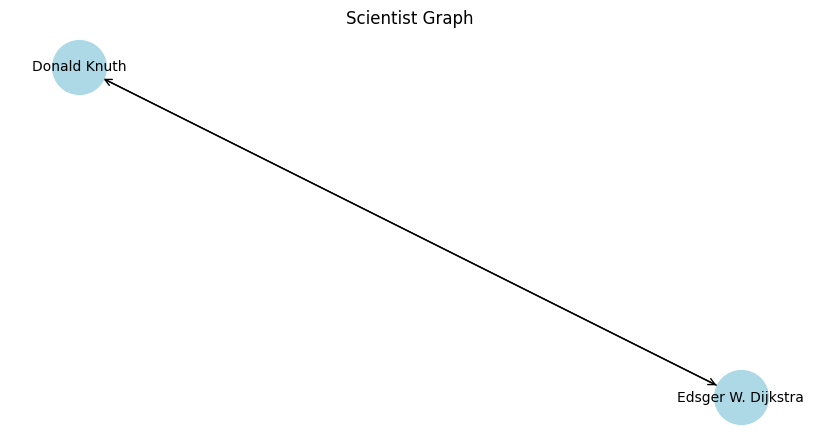

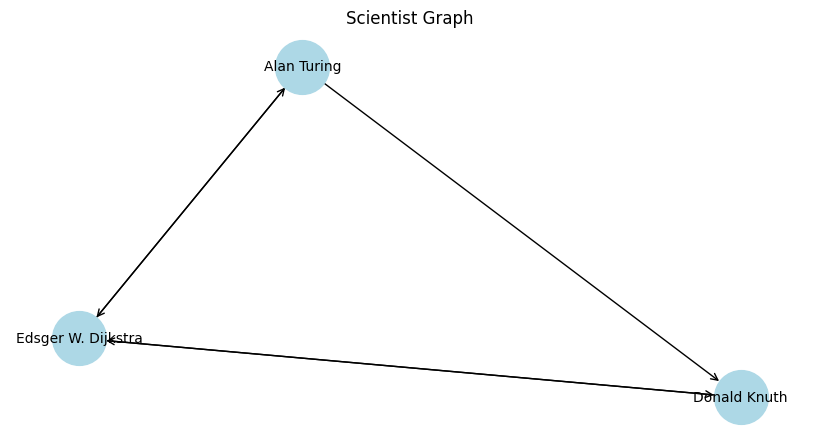

Rank by out-degree (descending):
Edsger W. Dijkstra: out-degree = 2
Alan Turing: out-degree = 2
Donald Knuth: out-degree = 1
Rank by PageRank (descending):
Edsger W. Dijkstra: PageRank = 0.4327
Donald Knuth: PageRank = 0.3333
Alan Turing: PageRank = 0.2339
Scientist 'Alan Turing' has been removed from the graph.


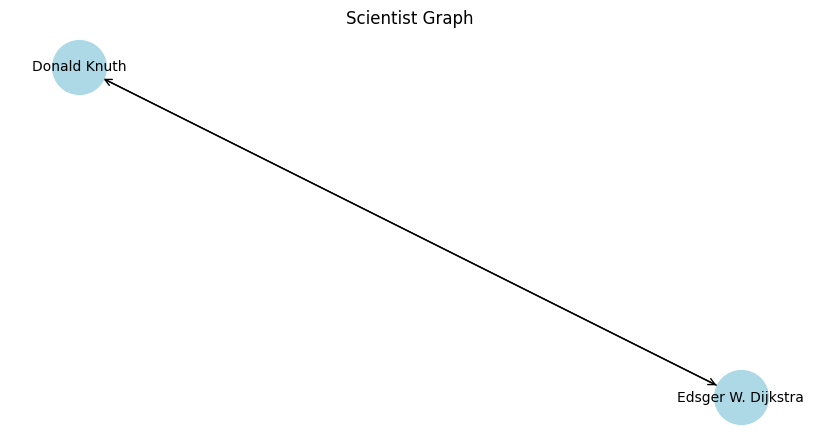

In [98]:
sg = ScientistGraph()
sg.add_scientist("Donald Knuth")
sg.add_scientist("Edsger W. Dijkstra")
sg.plot()
sg.add_scientist("Alan Turing")
sg.plot()
sg.rank_scientists(method='degree')
sg.rank_scientists(method='pagerank')
sg.remove_scientist("Alan Turing")
sg.plot()